# Barrents sea - Producer Notebook

## Introduction (TO EDIT)

**Goal: generate a temperature map at a given depth, and at a given time, and within given geographical boundaries!**


This Notebook provides guidance and support for data processing of CTD data, in particular by making use of the Geostatistical Library (RIntaros / RGeostats) for the modelisation of geostatistical relationships between variables, and to interpolate gridded data maps out of irregular CTD point measurements.

The CTD data access point is configured for the OPeNDAP Hyrax server operated by the Institute of Marine Research, Norwegian Marine Data Centre, Norway
http://opendap1.nodc.no/opendap/physics/point/yearly/contents.html

Note: for this server, the **.nc4** extension from the data access URLs is not supported.

The multi-year selection for CTD campaigns at sea is supported via the **year** parameter in the *fetch_data(url, year)* function in *helpers.py*, and consequently all the *fetch_data(url, year)* function calls within the Notebook. 

Citation: refer to the EC INTAROS project (https://cordis.europa.eu/project/id/727890).

# User-defined Input Parameters
These are the required input parameters that the user must define for the analysis, keeping in mind the goal of this notebook to **generate a temperature map at a given depth, and at a given time, and within given geographical boundaries**

## Import Libraries

In [126]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os

from helpers import *

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

from datetime import datetime, timedelta
import calendar

# !pip install lxml
from lxml import html
import requests

In [9]:
# Function to apply margin for extensions
margin = 20 # ie 20% of value
def applyMargin(value, f):
    """
    value: input value to apply the margin to
    f: flag, must be "low" or "high" for lower or higher boundary
    """
    if f == 'low': newvalue = value - (value * margin / 100)
    elif f == 'high': newvalue = value + (value * margin / 100)
    else: print('Wrong margin flag, must be "low" or "high".'); stop
    return newvalue

## Depth

In [75]:
# User-defined Depth (in meters)
depth = int(input('Insert the desired Depth (in meters): ')) #20

# Apply margins
depth1 = int(applyMargin(depth, f='low'))
depth2 = int(applyMargin(depth, f='high'))

# Display
print(f'User-defined Depth: {depth} meters')
print(f'Depth range (including margins): {depth1} - {depth2}')

Insert the desired Depth (in meters):  35


User-defined Depth: 35 meters
Depth range (including margins): 28 - 42


## Bounding Box (BBOX)

In [76]:
# User-defined bbox label and boundaries
bbox_key = 'UserAOI' # bbox label
bbox_usr = input('Insert the desired Bounding Box\n(in the format: minLong, maxLong, minLat, maxLat, eg: -5, 15, 53, 60): ') # [-5, 15, 53, 60] # bbox boundaries, in the format: minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80] 
bbox_usr = [int(i) for i in bbox_usr.split(', ')] # convert string to array of integers

# Apply margins
bbox0 = int(applyMargin(bbox_usr[0], f='low'))
bbox1 = int(applyMargin(bbox_usr[1], f='high'))
bbox2 = int(applyMargin(bbox_usr[2], f='low'))
bbox3 = int(applyMargin(bbox_usr[3], f='high'))
bbox_values = [bbox0, bbox1, bbox2, bbox3]
bbox_dict = {}
bbox_dict[bbox_key] = bbox_values

# Display
print(f"User-defined BBOX='{bbox_key}': {bbox_usr}")
print(f'BBOX range (including margins): {bbox_values}')

Insert the desired Bounding Box
(in the format: minLong, maxLong, minLat, maxLat, eg: -5, 15, 53, 60):  -5, 15, 53, 60


User-defined BBOX='UserAOI': [-5, 15, 53, 60]
BBOX range (including margins): [-4, 18, 42, 72]


## Time Range

In [137]:
# User-defined Month of interest start and end date in the format [day,month,year]
mmyyyy = input('Insert the month and year of interest (in the format MMYYYY): ') 
year = int(mmyyyy[2:])
month = int(mmyyyy[:2])

# assert month > 1 and month < 12, 'Month must be between 2-11, to include margin of same calendar year'

# Apply Margin
month1 = month - 1
month2 = month + 1

day_start = 1
day_end = calendar.monthrange(year, month2)[1] # only used for the last day of month

time_start = datetime(year, month1, day_start)
time_end = datetime(year, month2, day_end)

# Display
time_filter_str = f'{time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}'
print(f'User-defined Month: {datetime(year, month,1).strftime("%Y-%m")}')
print(f'Time range (including margins): {time_filter_str}')

Insert the month and year of interest (in the format MMYYYY):  102015


User-defined Month: 2015-10
Time range (including margins): 2015-09-01 - 2015-11-30


## Mesh

In [78]:
# User-define mesh (in degrees, equal for both long and lat)
mesh = int(input('Insert the resolution mesh (long and lat resolution of the final map, in degree, eg 1): ') )

# Display
print(f'User-defined Mesh: {mesh} degree')

Insert the resolution mesh (long and lat resolution of the final map, in degree, eg 1):  1


User-defined Mesh: 1 degree


# Extraction of NetCDF Data

## Exploratory Data Analysis

### Server URL

In [138]:
# Define URL of Norwegian Marine Data Centre (NODC) data
nodc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' # on NODC server

server_url = nodc_url

### Retrieval of DDS info
Access data using the dds info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION'

In [139]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

# get all content of the server_url, and then filter it with year and available platforms
page = requests.get(server_url)
webpage = html.fromstring(page.content)

urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(str(year)+'.nc.dds')]

for u in urls_filtered:
    
    dds = f'{server_url}/{u}'; print(dds)
    
    # Find platform code
    pc = dds.split('_')[0][-2:]
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'

# Extract platform_codes
platform_codes = [kd for kd in depth_stop_dict.keys()]
print(f'Available platforms in given year {year}: {platform_codes}')

# Print dimensions
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

http://opendap1.nodc.no/opendap/physics/point/yearly//58AA_CTD_2015.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58GS_CTD_2015.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58HJ_CTD_2015.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58JH_CTD_2015.nc.dds
http://opendap1.nodc.no/opendap/physics/point/yearly//58UO_CTD_2015.nc.dds
Available platforms in given year 2015: ['AA', 'GS', 'HJ', 'JH', 'UO']
TIME: {'AA': 937, 'GS': 545, 'HJ': 95, 'JH': 1270, 'UO': 231}
DEPTH: {'AA': 3054, 'GS': 3235, 'HJ': 2428, 'JH': 3827, 'UO': 1501}


### Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

#### Create *position_dict*
This dictionary is used to store xarray data and attributes for the variables 'TIME', 'LATITUDE', 'LONGITUDE' of the point measurements of the available platforms.

In [140]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2015.nc?TIME[0:1:937],LATITUDE[0:1:937],LONGITUDE[0:1:937]
Platform: GS. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2015.nc?TIME[0:1:545],LATITUDE[0:1:545],LONGITUDE[0:1:545]
Platform: HJ. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58HJ_CTD_2015.nc?TIME[0:1:95],LATITUDE[0:1:95],LONGITUDE[0:1:95]
Platform: JH. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58JH_CTD_2015.nc?TIME[0:1:1270],LATITUDE[0:1:1270],LONGITUDE[0:1:1270]
Platform: UO. URL with Queries: http://opendap1.nodc.no/opendap/physics/point/yearly/58UO_CTD_2015.nc?TIME[0:1:231],LATITUDE[0:1:231],LONGITUDE[0:1:231]


#### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**LONGITUDE** and **LATITUDE**) and respective **TIME** for all platforms, in order to plot and visualise them.

In [141]:
# Load locations (long & lat) and TIME of ALL measurements
start_date = datetime(1950, 1, 1)
    
position_df = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df = position_df.append(test) 
    
position_df['Index_ABS'] = np.arange(0,len(position_df))
position_df = position_df.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df)} measurement locations')
position_df

Platform AA: 938 measurement locations.


Longitude   Latitude                Time Platform
933   6.225500  60.448502 2015-12-15 02:17:24       AA
934   5.899200  59.980801 2015-12-15 10:26:30       AA
935   5.462800  59.516201 2015-12-15 15:37:34       AA
936   5.547000  59.638302 2015-12-15 18:20:06       AA
937   5.556111  59.641666 2015-12-15 18:20:06       AA

Platform GS: 546 measurement locations.


Longitude   Latitude                Time Platform
541   0.083667  60.750702 2015-11-26 05:27:25       GS
542  -0.266000  60.749802 2015-11-26 06:56:10       GS
543  -0.464833  60.750198 2015-11-26 07:55:45       GS
544  -0.666944  60.758888 2015-11-26 09:21:17       GS
545  -0.666833  60.748699 2015-11-26 09:21:17       GS

Platform HJ: 96 measurement locations.


Longitude   Latitude                Time Platform
91    8.49100  79.663696 2015-09-03 22:12:09       HJ
92    9.07933  79.667297 2015-09-04 09:41:19       HJ
93    9.72200  79.676498 2015-09-04 17:37:48       HJ
94    8.08100  79.135300 2015-09-05 04:14:06       HJ
95    9.11533  78.616997 2015-09-05 13:50:09       HJ

Platform JH: 1271 measurement locations.


Longitude   Latitude                Time Platform
1266  19.903200  70.999702 2015-11-25 20:52:10       JH
1267  19.936199  70.834000 2015-11-25 22:35:16       JH
1268  19.977501  70.668335 2015-11-25 23:45:03       JH
1269  19.973200  70.667702 2015-11-25 23:45:03       JH
1270  20.003799  70.501297 2015-11-26 00:58:39       JH

Platform UO: 232 measurement locations.


Longitude  Latitude                Time Platform
227  97.147003  10.02570 2015-05-29 20:24:51       UO
228  96.739799  10.01670 2015-05-30 01:30:02       UO
229  96.431000   9.99533 2015-05-30 03:44:10       UO
230  96.334801  10.04120 2015-05-30 05:12:15       UO
231  97.795303  10.12880 2015-05-30 16:02:48       UO


Merged dataframe with all platforms. Total of 3083 measurement locations


Longitude   Latitude                Time Platform  Index_ABS
Index_Relative                                                              
0                5.313000  60.411499 2015-01-09 10:29:25       AA          0
1                8.143830  58.044998 2015-01-17 08:25:57       AA          1
2                8.216000  58.023499 2015-01-17 19:13:04       AA          2
3                8.303670  58.018799 2015-01-17 20:56:15       AA          3
4                8.306111  58.020279 2015-01-17 20:56:15       AA          4
...                   ...        ...                 ...      ...        ...
227             97.147003  10.025700 2015-05-29 20:24:51       UO       3078
228             96.739799  10.016700 2015-05-30 01:30:02       UO       3079
229             96.431000   9.995330 2015-05-30 03:44:10       UO       3080
230             96.334801  10.041200 2015-05-30 05:12:15       UO       3081
231             97.795303  10.128800 2015-05-30 16:02:48       UO       3082

[3083 rows x 5 columns]

#### Plot Histogram of measurements of the given year

<AxesSubplot:title={'center':'Histogram of available measurements in 2015'}, xlabel='Month', ylabel='Frequency'>

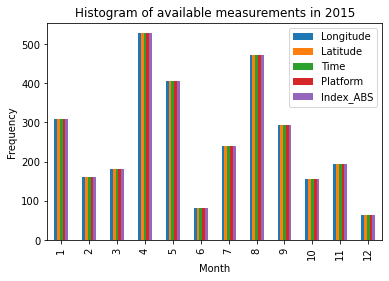

In [142]:
position_df.groupby(position_df["Time"].dt.month).count().plot(kind="bar", 
                                                               title=(f'Histogram of available measurements in {year}'),
                                                               xlabel='Month',
                                                               ylabel='Frequency')

#### Plot Positions
Plot locations on an interactive plot. Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [151]:
def plotIteractive(df2p, title, xlim, ylim, bbox=False):
    output_notebook() # necessary to show the plot 

    hover = HoverTool(
            tooltips=[
                ("index", "$index"),
                ("(x,y)", "($x, $y)"),
                ("Platform", "@Platform"),            
            ]
        )

    p = figure(plot_width=500, 
               plot_height=500, 
               tools=[hover],
               title=title,
               x_range=xlim, 
               y_range=ylim)

    # p.square('Longitude', 'Latitude', size=6, color='grey', fill_color='white', source=df2p, legend_label="All locations")
    if any(df2p['Platform']=='AA'): p.circle('Longitude', 'Latitude', size=4, color='red', fill_color='white', source=df2p[df2p['Platform']=='AA'], legend_label="Platform AA")
    if any(df2p['Platform']=='GS'): p.circle('Longitude', 'Latitude', size=4, color='blue', fill_color='white', source=df2p[df2p['Platform']=='GS'], legend_label="Platform GS")
    if any(df2p['Platform']=='GT'): p.circle('Longitude', 'Latitude', size=4, color='green', fill_color='white', source=df2p[df2p['Platform']=='GT'], legend_label="Platform GT")
    if any(df2p['Platform']=='HJ'): p.circle('Longitude', 'Latitude', size=4, color='black', fill_color='white', source=df2p[df2p['Platform']=='HJ'], legend_label="Platform HJ")
    if any(df2p['Platform']=='JH'): p.circle('Longitude', 'Latitude', size=4, color='orange', fill_color='white', source=df2p[df2p['Platform']=='JH'], legend_label="Platform JH")

    # Add area
    if bbox: 
        bbox_val = list(bbox_dict.values())[0]
        p.quad(left=bbox_val[0], right=bbox_val[1], top=bbox_val[3], bottom=bbox_val[2], 
               legend_label=list(bbox_dict.keys())[0], fill_color='grey', fill_alpha=0.0, line_color="black")

    p.legend.location = "bottom_right"
    show(p)

In [152]:
xlim = (min(position_df['Longitude'])-1, max(position_df['Longitude'])+1)
ylim = (min(position_df['Latitude'])-1, max(position_df['Latitude'])+1)

title = f'All measurement points'
plotIteractive(position_df, title, xlim, ylim, bbox=False)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the 'LATITUDE', 'LONGITUDE' and 'TIME' dimensions. First, the data is filtered by bounding box (BBOX). Subsequently, this data is further filtered using a time range.

#### Filter by BBOX

In [153]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox_values[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox_values[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox_values[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox_values[3])]

print(f'BBOX={bbox_key} range (including margins): {bbox_values}')
sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox)

title = f'Filtered data: BBOX={bbox_key}'
plotIteractive(position_df_bbox, title, xlim, ylim, bbox_dict)

BBOX=UserAOI range (including margins): [-4, 18, 42, 72]
Selected positions (out of available positions): 1601 out of 3083.


Longitude   Latitude                Time Platform  Index_ABS
Index_Relative                                                              
0                5.313000  60.411499 2015-01-09 10:29:25       AA          0
1                8.143830  58.044998 2015-01-17 08:25:57       AA          1
2                8.216000  58.023499 2015-01-17 19:13:04       AA          2
3                8.303670  58.018799 2015-01-17 20:56:15       AA          3
4                8.306111  58.020279 2015-01-17 20:56:15       AA          4
...                   ...        ...                 ...      ...        ...
1228            11.610700  69.233200 2015-11-21 08:04:16       JH       2808
1229            10.949300  69.485001 2015-11-21 12:19:23       JH       2809
1230            10.257700  69.704803 2015-11-21 16:11:58       JH       2810
1231             9.565000  69.954300 2015-11-21 22:25:33       JH       2811
1232             9.575000  69.957222 2015-11-21 22:25:33       JH       2812

[1601 rows x 5 columns]

Loading BokehJS ...

#### Filter by BBOX, adding Time Range filter

In [154]:
position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]

print(f'BBOX={bbox_key} range (including margins): {bbox_values}')
print(f'Time range (including margins): {time_filter_str}')
sel_outof_all = f'{len(position_df_bbox_timerange)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox_timerange)

title = f'Filtered data: BBOX={bbox_key} and Time={time_filter_str}'
plotIteractive(position_df_bbox_timerange, title, xlim, ylim, bbox_dict)

BBOX=UserAOI range (including margins): [-4, 18, 42, 72]
Time range (including margins): 2015-09-01 - 2015-11-30
Selected positions (out of available positions): 285 out of 3083.


Longitude   Latitude                Time Platform  Index_ABS
Index_Relative                                                              
743              5.169170  60.514500 2015-09-14 09:55:34       AA        743
744              4.985670  60.586201 2015-09-14 11:20:55       AA        744
745              4.987222  60.588055 2015-09-14 11:20:55       AA        745
746              5.368670  60.869499 2015-09-16 06:41:29       AA        746
747              5.366330  60.869801 2015-09-16 22:33:06       AA        747
...                   ...        ...                 ...      ...        ...
1228            11.610700  69.233200 2015-11-21 08:04:16       JH       2808
1229            10.949300  69.485001 2015-11-21 12:19:23       JH       2809
1230            10.257700  69.704803 2015-11-21 16:11:58       JH       2810
1231             9.565000  69.954300 2015-11-21 22:25:33       JH       2811
1232             9.575000  69.957222 2015-11-21 22:25:33       JH       2812

[285 rows x 5 columns]

Loading BokehJS ...

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [155]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None)
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

#### Define Filtered Dataframe (*df_toPlot*) to be used for online querying of the filtered positions
Define the filtered dataframe (eg *position_df_bbox*, *position_df_bbox_timerange*), to be named **df_toPlot**, and the dictionary of indices of filtered data (to be named **index_dict**), to use for further filtering.

In [156]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange # or position_df / position_df_bbox

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Filtered positions in "BBOX={bbox_key}" and "Time range={time_filter_str}" (out of available positions): {sel_outof_all}')

display(df_toPlot)

Filtered positions in "BBOX=UserAOI" and "Time range=2015-09-01 - 2015-11-30" (out of available positions): 285 out of 3083.


Longitude   Latitude                Time Platform  Index_ABS
Index_Relative                                                              
743              5.169170  60.514500 2015-09-14 09:55:34       AA        743
744              4.985670  60.586201 2015-09-14 11:20:55       AA        744
745              4.987222  60.588055 2015-09-14 11:20:55       AA        745
746              5.368670  60.869499 2015-09-16 06:41:29       AA        746
747              5.366330  60.869801 2015-09-16 22:33:06       AA        747
...                   ...        ...                 ...      ...        ...
1228            11.610700  69.233200 2015-11-21 08:04:16       JH       2808
1229            10.949300  69.485001 2015-11-21 12:19:23       JH       2809
1230            10.257700  69.704803 2015-11-21 16:11:58       JH       2810
1231             9.565000  69.954300 2015-11-21 22:25:33       JH       2811
1232             9.575000  69.957222 2015-11-21 22:25:33       JH       2812

[285 rows x 5 columns]

#### Check Duplicates (if any)

In [188]:
# Create duplicate Mask (keep all duplicates)
dupli_mask = df_toPlot.duplicated(subset='Time', keep=False)

# If duplicates exists, plot duplicates and assign them to df_toPlot
if len(dupli_mask[dupli_mask]) > 0:
    
    dupli = df_toPlot[dupli_mask]
    
    xlim_dupli = (min(dupli['Longitude'])-1, max(dupli['Longitude'])+1)
    ylim_dupli = (min(dupli['Latitude'])-1, max(dupli['Latitude'])+1)

    plotIteractive(dupli, 'Duplicates', xlim_dupli, ylim_dupli, bbox_dict)
    
    df_toPlot = dupli

display(df_toPlot)

Loading BokehJS ...

Longitude   Latitude                Time Platform  Index_ABS
Index_Relative                                                              
744              4.985670  60.586201 2015-09-14 11:20:55       AA        744
745              4.987222  60.588055 2015-09-14 11:20:55       AA        745
747              5.366330  60.869801 2015-09-16 22:33:06       AA        747
748              5.377222  60.871944 2015-09-16 22:33:06       AA        748
758              5.509500  59.741299 2015-09-24 11:47:43       AA        758
...                   ...        ...                 ...      ...        ...
1218            14.266700  69.002502 2015-11-19 23:21:24       JH       2798
1225            12.796300  68.851501 2015-11-20 22:10:48       JH       2805
1226            12.805000  68.852501 2015-11-20 22:10:48       JH       2806
1231             9.565000  69.954300 2015-11-21 22:25:33       JH       2811
1232             9.575000  69.957222 2015-11-21 22:25:33       JH       2812

[96 rows x 5 columns]

In [190]:
index_dict = {}

for pc in df_toPlot['Platform'].unique():
    index_dict[pc] = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

# index_dict

{'AA': [744,
  745,
  747,
  748,
  758,
  759,
  788,
  789,
  791,
  792,
  794,
  795,
  802,
  803,
  807,
  808,
  812,
  813,
  817,
  818,
  822,
  823,
  825,
  826,
  829,
  830,
  832,
  833,
  835,
  836,
  838,
  839,
  850,
  851,
  860,
  861,
  863,
  864,
  870,
  871],
 'GS': [435,
  436,
  438,
  439,
  501,
  502,
  508,
  509,
  513,
  514,
  525,
  526,
  536,
  537,
  544,
  545],
 'JH': [1112,
  1113,
  1118,
  1119,
  1121,
  1122,
  1124,
  1125,
  1128,
  1129,
  1131,
  1132,
  1136,
  1137,
  1141,
  1142,
  1144,
  1145,
  1147,
  1148,
  1153,
  1154,
  1156,
  1157,
  1174,
  1175,
  1189,
  1190,
  1193,
  1194,
  1204,
  1205,
  1211,
  1212,
  1217,
  1218,
  1225,
  1226,
  1231,
  1232]}

## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables accessing data of **only the selected variable** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Data Extraction

### Define Variables

In [191]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variable to use for the analysis
vars_sel = ['TEMP', 'CNDC', 'PSAL']; assert all([elem in vars_main for elem in vars_sel])

### Create **data_dict** dictionary 
Once variables are defined, the DEPTH range must be defined. 

**INSERT BELOW** the desired DEPTH range (in meters) in the two fields of hte following cell, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

Once the variables and DEPTH range are defined, data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

In [192]:
data_dict = {}
metadata = {}

for pc in df_toPlot['Platform'].unique():
    
    metadata[pc] = {}

    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 0
    metadata[pc]['depth_m_v2'] = depth2 #pc_dim_dict[pc]['DEPTH'] 
    # ==============================================================================

    # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

    #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

    metadata[pc]['depth_newindex4xr_v1'] = 0

    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for v in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)

    # Build url and url with queries (url_q)
    url = f'{server_url}{fix_lab}.nc?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

    remote_data, data_attr = fetch_data(url_q, year)

    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}

    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 3054,
 'depth_m_v1': 0,
 'depth_m_v2': 42,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 42,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 42,
 'vmin': 1}
AA DEPTH range of interest (adjusted with vmin): 0 - 42
Platform AA URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58AA_CTD_2015.nc?TIME[0:1:937],LATITUDE[0:1:937],LONGITUDE[0:1:937],TEMP[0:1:937][0:1:42]
['58AA' 'H\\303\\245kon Mosby' '2015' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '1.000'
 '3060.000' '-13.784' '27.037' '54.011' '80.698']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3235,
 'depth_m_v1': 0,
 'depth_m_v2': 42,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 42,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 42,
 'vmin': 0}
GS DEPTH range of interest (adjusted with vmin): 0 - 42
Platform GS URL: http://opendap1.nodc.no/opendap/physics/point/yearly/58GS_CTD_2015.nc?TIME[0:1:545],LATITUDE[0:1:545],LONGITUDE[0:1:545],

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe overview_df is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [193]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

Platform_code       Platform_name    Year                    Data_type  \
AA          58AA  H\303\245kon Mosby  2015.0  OceanSITES vertical profile   
GS          58GS           G.O. Sars  2015.0  OceanSITES vertical profile   
JH          58JH         Johan Hjort  2015.0  OceanSITES vertical profile   

                                            Title   Instrument  Vertical_min  \
AA  Arctic Ocean - In Situ Observation Copernicus  CTD Seabird           1.0   
GS  Arctic Ocean - In Situ Observation Copernicus  CTD Seabird           0.0   
JH  Arctic Ocean - In Situ Observation Copernicus  CTD Seabird           1.0   

    Vertical_max  Lon_min  Lon_max  Lat_min  Lat_max  
AA        3060.0  -13.784   27.037   54.011   80.698  
GS        3241.0  -40.738   36.598   54.121   75.041  
JH        3829.0   -2.244   48.597   56.164   81.011

In [202]:
# Extract / define the variables to use for the analysis
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in data_dict.keys():
    print(f'{k}; Initial DEPTH range: {metadata[k]["depth_m_v1"]}-{metadata[k]["depth_m_v2"]}m; VARS: {list(data_dict[k]["data"].variables)}')


Printing DEPTH range for analyis:
AA; Initial DEPTH range: 0-42m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GS; Initial DEPTH range: 0-42m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
JH; Initial DEPTH range: 0-42m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']


In [203]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'AA': {'TEMP': False}, 'JH': {'TEMP': False}}

### Data Filtering by DEPTH
This section allows adding the filter based on DEPTH on the previously filtered data (based on BBOX and time range).

The output of this operation is a *filtered_xarr* xarray dataset, containing one variable at the specified DEPTH range. 

#### Data filtered by DEPTH

In [204]:
filtered_xarr_dict = {}

for pc in data_dict.keys():
    
    # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False

    for v in vars_sel: 
        check_alignment(data_dict, pc, v, align_and_nan, vmin_dict)

    filtered_xarr_dict[pc] = filter_xarr_DEPTH(df_toPlot, 
                                               data_dict,
                                               platform=pc,
                                               depth_range=[depth1, depth2])
display(filtered_xarr_dict)

Platform: AA; Vertical min: 1.0; Var: TEMP --> aligning and add nan
Platform: GS; Vertical min: 0.0; Var: TEMP
Platform: JH; Vertical min: 1.0; Var: TEMP --> aligning and add nan


{'AA': <xarray.Dataset>
 Dimensions:    (DEPTH: 15, LATITUDE: 40, LONGITUDE: 40, TIME: 40)
 Coordinates:
   * TIME       (TIME) float64 2.4e+04 2.4e+04 2.4e+04 ... 2.406e+04 2.406e+04
   * LATITUDE   (LATITUDE) float32 60.59 60.59 60.87 60.87 ... 61.11 60.94 60.94
   * LONGITUDE  (LONGITUDE) float32 4.986 4.987 5.366 5.377 ... 6.49 7.172 7.176
 Dimensions without coordinates: DEPTH
 Data variables:
     TEMP       (TIME, DEPTH) float64 11.63 11.57 11.52 ... 10.42 10.33 10.34
 Attributes: (12/163)
     _NCProperties:                  version=1|netcdflibversion=4.4.1|hdf5libv...
     title:                          Arctic Ocean - In Situ Observation Copern...
     qc_manual:                      Recommendations for in-situ data Near Rea...
     contact:                        cmems-service@imr.no
     format_version:                 1.4
     distribution_statement:         These data follow Copernicus standards; t...
     ...                             ...
     CNDC_DM._FillValue:      

### Aggregation of Available Platforms
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. First check the dimensions of DEPTH are the same.

In [205]:
# Dictionary of variables for each platform
data_var_dict = {}
depth_arr = []

for pc in data_dict.keys():
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    depth_dim_pc = data.dims["DEPTH"]
    depth_arr.append(depth_dim_pc)
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')
    
    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]
        
assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
# display(data_var_dict)

PC AA	Filtered Dims: TIME=40, DEPTH=15
PC GS	Filtered Dims: TIME=16, DEPTH=15
PC JH	Filtered Dims: TIME=40, DEPTH=15


Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

In [206]:
f = np.array([])

for pc in data_dict.keys(): 
    f = np.append(f, data_var_dict[pc][var]['TIME'].data)

f.sort()
print(f)

[23984.90663194 23984.90663194 23985.79695602 23985.79695602
 23997.4728588  23997.4728588  23999.93965278 23999.93965278
 24007.49146991 24007.49146991 24008.77118056 24008.77118056
 24023.74362269 24023.74362269 24024.8112037  24024.8112037
 24025.8815162  24025.8815162  24030.58393519 24030.58393519
 24031.97194444 24031.97194444 24032.89366898 24032.89366898
 24033.54667824 24033.54667824 24033.93913194 24033.93913194
 24034.95759259 24034.95759259 24035.83884259 24035.83884259
 24035.95541667 24035.95541667 24036.67012731 24036.67012731
 24036.82246528 24036.82246528 24037.94653935 24037.94653935
 24038.72731481 24038.72731481 24039.38190972 24039.38190972
 24039.56297454 24039.56297454 24039.77621528 24039.77621528
 24040.84700231 24040.84700231 24040.87170139 24040.87170139
 24041.88574074 24041.88574074 24043.85609954 24043.85609954
 24044.51983796 24044.51983796 24047.94032407 24047.94032407
 24048.91623843 24048.91623843 24049.56373843 24049.56373843
 24053.99465278 24053.994

In [208]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
    print('ERROR HERE')    
    merged_arr[var] = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys()])  
        
    title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_filter_str};\nBBOX={bbox_key}; Depth Range {depth1}-{depth2}m;\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)
display(merged_arr)

ERROR HERE


ValueError: cannot reindex or align along dimension 'TIME' because the index has duplicate values

### Create Dataframe of Filtered XARRAY
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file expected by the RGeostats module.


In [ ]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 
                
        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vaissel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

### Assign *Profil_id* to the unique positions

In [ ]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

#### Plot Histogram of measurements of the given year

In [ ]:
# Create a copy (I need to keep the original as it is, because Time needs to be a floating number)
filtered2csv_multiDepths_time = filtered2csv_multiDepths.copy()

# Convert Time from float to datetime
filtered2csv_multiDepths_time['Time'] = [start_date + timedelta(t) for t in filtered2csv_multiDepths_time.loc[:,'Time']]

# Plot Histogram
filtered2csv_multiDepths_time.groupby([filtered2csv_multiDepths_time["Time"].dt.month,
                                  filtered2csv_multiDepths_time["Time"].dt.day]).count().plot(kind="bar", 
                                                                                         legend=False, 
                                                                                         xlabel='Month & Day',
                                                                                         ylabel='Count'
                                                                                        )

### Export to CSV

In [ ]:
# Save dataframe to csv
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)

csvname = os.path.join(data_output, 
                       f'filtered_BBOX={bbox_key}_MMYYYY={str(month).zfill(2)}{year}_\
                       Depth={depth1}-{depth2}m_VARS={"_".join(vars_sel)}.csv')

filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)

# Geostatistical Analysis with RGeostats
## Set-up

### Install R Kernel & Testing

In [ ]:
!pip install rpy2

%load_ext rpy2.ipython

### Import variables from Python

In [ ]:
import rpy2.robjects as robjects

# BBOX (note it's stored as an array of format: [minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80]]
robjects.globalenv['bbox_key'] = bbox_key
robjects.globalenv['long_min'] = bbox_values[0]
robjects.globalenv['long_max'] = bbox_values[1]
robjects.globalenv['lat_min'] = bbox_values[2]
robjects.globalenv['lat_max'] = bbox_values[3]

# Time Range
robjects.globalenv['time_filter_str'] = time_filter_str

# Depth Range
robjects.globalenv['depth'] = depth
robjects.globalenv['depth1'] = depth1
robjects.globalenv['depth2'] = depth2

# Mesh
robjects.globalenv['mesh'] = mesh

# Directory and CSV Name
robjects.globalenv['data_output'] = data_output 
robjects.globalenv['csvname'] = csvname

# Variables
robjects.globalenv['vars'] = '_'.join(vars_sel) 

In [ ]:
%%R
# Check Variables
print('Printing variables imported from Python script')
cat('bbox_key:', bbox_key, '\n')
long_lim   = c(long_min, long_max)
lat_lim    = c(lat_min, lat_max)
cat('long_lim:', long_lim, '\n')
cat('lat_lim:', lat_lim, '\n')
cat('time_filter_str:', time_filter_str, '\n')
cat('depth:', depth, '\n')
cat('depth1:', depth1, '\n')
cat('depth2:', depth2, '\n')
cat('mesh:', mesh, '\n')
cat('data_output:', data_output, '\n')
cat('csvname:', csvname, '\n')
cat('vars:', vars, '\n')

## Definition of the environment

The next cells have specific contents for loading the library **RIntaros** that the user must choose to run or to skip. Their order is important.

In [ ]:
%%R 
suppressWarnings(suppressPackageStartupMessages(library(RIntaros)))

# Defining if the data set must be read or not from the CSV (flag.read)
flag.read = FALSE

## Loading Data

First of all, we setup some environment variables (data file name and bounding box).
The **flag_file** allows the user to store each generated graphic file as a **PNG** file in the **image_name** directory, instead of plotting them.

In [ ]:
%%R 
# Setup OUR environment and datasets 
dir.name   = getwd()
data.name  = basename(data_output)
file.name  = basename(csvname)

intaros.save.environ(long_lim = long_lim, lat_lim = lat_lim,
                     flag_file = FALSE)

var = "Temperature"

Then we read the **CSV** file (taking the header line into account) and create the RGeostats Db. Finally we show the contents of the newly created Db (named **db0**).

In [ ]:
%%R 
if (flag.read || ! exists("db0")) db0 = imr_read_csv(file.path(dir.name,data.name,file.name))
db0

## Dataset global statistics

We first establish the time amplitude of the dataset, as well as a set of colors assigned to each year.

In [ ]:
%%R
years      = subyears = get_db_limits_year(db0)
colyears   = rg.colors(length(years))
cat(build_title("The dataset period is:",time2date(get_db_limits_time(db0))))

Let us get some statistics on the information available

In [ ]:
%%R
db.stat.print(db0,funs=c("num","mini","maxi","mean"),
              names=c("Longitude","Latitude","Depth","Temperature"))#,"Conductivity","Salinity"))

### Studying Temperature variable

From this point, most of the calculations will be performed based on the **Temperature** variable.

#### All Database

We display all samples focusing on the variable in a 2D aerial view, reporting the country borders. For comparison, we define a common color scale, established on the global minimum and maximum values (**var_scale0**).
Note that all samples from all years and all depths are displayed (slow operation).

In [ ]:
%%R
colors.temp = rg.colors(rank=1)
var_scale0 = get_db_limits_var(db0,var)
display_var(db0, var = var, colors = colors.temp, title = var, filename = var)

### Block Average at the given Depth

The next display considers the variable averaged over the cells of a coarse grid (mesh of 1 degree).

In [ ]:
%%R
var = "Temperature"

# Select samples and set the color scale
db1       = apply_sel(db0, depth_lim=c(depth1,depth2),compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following line if you want to to display all years
subyears = years[1]

date_lim  = create_limits_date(years[1])
db        = apply_sel(db1, date_lim=date_lim)
filename  = paste0(var,"_Mean_",years[1])
title     = paste("Block Average for", build_title(var, date_lim))
dbg       = stats_grid(db, var, fun = "mean", mesh = 1)
display_stats(dbg, var, var_scale = var_scale, colors = colors.temp,
            title = title, filename = filename)

## Import in RGeostats database structure

### Histogram of Measurement Depths

We also aggregate the values of all samples vertically from 0m to 100m by 10 steps of 10m.
Then, we can double-check this regularization step by plotting the histogram of the initial depths and the histogram of the depths in the aggregated file.

In [ ]:
%%R
# Histogram of depths
hist(time2date(db0[,"Time"]),breaks=100,xlab="Time",main="")

## Horizontal Variogram per Year

Review the horizontal variograms for different years at 25m depth, calculated from the aggregated data set.

In [ ]:
%%R
# Define the active samples
depth_lim = c(depth1,depth2)
dbr       = db.locate(db0,var,"z")

# Variogram parameters
vario_lag  = 0.5
vario_nlag = 20
varmax = 2

# Loop on the years
ecr = 1
add = FALSE
for (year in years) 
{
  date_lim = create_limits_date(year)
  dbr = remove_sel(dbr)
  dbr = apply_sel(dbr, date_lim = date_lim)

  vario = prepar_vario(dbr, dirvect=NA, 
                       vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario=TRUE,
                       add=add, ylim=c(0,varmax), col=colyears[ecr], lwd=1,
                       varline=FALSE, npairdw=TRUE)

  ecr = ecr + 1
  add = TRUE
}
legend("right",legend=years,col=colyears,lty=1,lwd=2,cex=0.8)

## Cross-Validation

We first perform a cross-validation step to estimate the cross-validation Standard Error of the model.

In [ ]:
%%R 
# Define the active samples
depth_lim = c(depth1,depth2)
date_lim  = create_limits_date(year) 

# Variogram parameters
vario_lag  = vario_lag #0.5
vario_nlag = vario_nlag #20

# Perform the Cross-validation (includes Variogram calculation and Model fitting)
dbp = xvalid_2D(dbr, var,  
                vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                dirvect = NA, draw.model=TRUE, radix="Xvalid")
db.stat.print(dbp,names="Xvalid*",funs=c("num","mean","var"),title="Cross-Validation Scores")

# Display the results
filename  = paste0("Xvalid_",var)
display_var(dbp, var = "*stderr", flag.xvalid = TRUE,
            title = paste(var, 'Cross-Validation Standard Error'), filename = filename, pos.legend=7)

## 2-D Estimation of Temperature

We interpolate the Temperature for the given bounding box, at the given depth, and given time interval.

In [ ]:
%%R 
# Select the active samples
depth = 20

# Variogram parameters
vario_lag  = vario_lag # 0.5
vario_nlag = vario_nlag # 20

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(db0, var, mesh = 0.5, moving=FALSE,
                     vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                     dirvect = NA, draw.model=TRUE, pos.legend=1)

# Display the results
filename  = paste0(var,".Estim2D_Year_",year)
display_result(db0, dbg, var = var, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, filename = filename, pos.legend=7)